In [1]:
import pandas as pd
import cobra
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import linprog
import scipy
import warnings
warnings.filterwarnings('ignore')

# Community modeling

In this notebook we will implement a method to create community models of two or more species specific metabolic models using cobrapy.

In [2]:
model_DP = cobra.io.read_sbml_model("models/consistent_DP_SNM.xml")
model_SA = cobra.io.read_sbml_model("models/consistent_iYS854_SNM.xml")
print("Growth: ", model_DP.slim_optimize())
print("Growth: ", model_SA.slim_optimize())

Growth:  0.2823653925322476
Growth:  2.558694612613393


In [3]:
for rec in model_SA.reactions:
    rec.lower_bound = max(rec.lower_bound, -1000)
    rec.upper_bound = min(rec.upper_bound, 1000)

In [4]:
snm3 = pd.read_csv("SNM3.csv", sep =";")
snm3.head()

,Compound,BiGG,ModelSeed,KEGG
0,Alanine,ala__L,cpd00035,C00041
1,Arginine,arg__L,cpd00051,C00062
2,Cysteine,cys__L,cpd00084,C00097
3,Glutamic acid,glu__L,cpd00023,C00025
4,Glycine,gly,cpd00033,C00037


In [5]:
BIOMASS_DP = "Growth" 
BIOMASS_SA = "BIOMASS_iYS_wild_type"
models = [model_DP.copy(), model_SA.copy()]

## 1) Constructing of community model explicitely

In [6]:
def create_stoichiometry_matrix(model):
    metabolites = model.metabolites 
    reactions = model.reactions 
    S = np.zeros((len(metabolites), len(reactions)))
    
    met_id = dict()
    rec_id = dict()
    for i,reaction in enumerate(model.reactions):
        rec_id[reaction.id] = i
        for metabolite, stoich in reaction.metabolites.items():
            met_id[metabolite.id] = int(metabolites.index(metabolite))
            S[metabolites.index(metabolite), i] = stoich
    return S, met_id, rec_id 

In [7]:
class Model():
    def __init__(self, model, biomass_function):
        """ This is a new class of metabolic model, capable of flux balance analysis
        Attributes:
        models (list): CobraPy models of single organisms which will be used in construction
        biomass_reactions (list): List of strings containing the ids for the growth reactions
        """
        self.biomass_function = biomass_function
        self.model = model
        self.id = model.id
        # Compute stoichimetry_matrix
        S, met_id, rec_id = create_stoichiometry_matrix(model)
        self.num_reactions = S.shape[1]
        self.num_metabolites = S.shape[0]
        self.stoichiometry_matrix = scipy.sparse.csr_matrix(S)
        self.met_id = met_id
        self.rec_id = rec_id 
        # Set objective
        idx = self.rec_id[biomass_function]
        c = np.zeros(self.num_reactions)
        c[idx] = 1
        self.objective_c = c
        self.medium = model.medium
        # Set bounds
        self._reset_bounds()
    
    @property
    def reactions(self):
        return self.model.reactions
    @property
    def exchanges(self):
        return self.model.exchanges
    @property
    def metabolites(self):
        return self.model.metabolites


    def set_medium(self, medium):
        ex_ids = [ex.id for ex in self.exchanges]
        new_med = {}
        for key,val in medium.items():
            if key in ex_ids:
                new_med[key] = val
        self.model.medium = new_med
        self._reset_bounds()
        
    def optimize(self, disp=False):
        sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
        sol["fun"] = -sol["fun"] # As we have to minimize
        return sol 
    
    def slim_optimize(self, disp=False):
        sol = self.optimize(disp=disp)
        return sol["fun"]

    def summary(self):
        sol = self.optimize()
        flux = sol["x"]
        ex_ids = [ex.id for ex in self.exchanges]
        fluxes = []
        for ex in ex_ids:
            idx = self.rec_id[ex]
            fluxes.append(flux[idx])
        summary_df = pd.DataFrame({"Exchange reaction": ex_ids, "Flux": fluxes})
        summary_df.sort_values(["Flux"], inplace=True)
        return summary_df

    def _reset_bounds(self):
        self.bounds = []
        for rec in self.model.reactions:
            self.bounds.append((rec.lower_bound, rec.upper_bound))

    def __add__(self, model2):
        """ Adding another model creates a community model """
        return CommunityModel([self,model2], [1.,1.])
    

In [8]:
class CommunityModel(Model):
    def __init__(self, models, weight):
        self.models = models
        self.id = "|".join([model.id for model in models])
        self.shared_exchanges = []
        self.weight = weight
        for model in models:
            for rec in model.exchanges:
                if rec.id not in self.shared_exchanges:
                    self.shared_exchanges.append(rec.id)
        # Create community stoichimetry matrix with shuttel reactions!
        self._shifts = [len(self.shared_exchanges)]
        for i,model in enumerate(models):
            self._shifts.append(self._shifts[i] + model.num_reactions)
        S_EX = -np.eye(self._shifts[0])
        matrices = [S_EX] + [m.stoichiometry_matrix.todense() for m in models]
        S = scipy.linalg.block_diag(*matrices)
        self.num_reactions = S.shape[1]
        self.num_metabolites = S.shape[0]
        for i, id in enumerate(self.shared_exchanges):
            for j,model in enumerate(models):
                if id in model.rec_id:
                    S[i,self._shifts[j] + model.rec_id[id]] = 1
        self.stoichiometry_matrix = scipy.sparse.csr_matrix(S)
        # Cretae objective:
        self._weighted_objective(weight)
        # Create bounds
        self._reset_bounds()
    
    @property
    def reactions(self):
        return [model.reactions for model in self.models]
    @property
    def exchanges(self):
        return self.shared_exchanges
    @property
    def metabolites(self):
        return [model.metabolites for model in self.models]
    @property
    def medium(self):
        medium = {}
        for model in self.models:
            for key,val in model.medium.items():
                medium[key] = val
        return medium

    def _weighted_objective(self, weight):
        self.weight = weight
        self.objective_c = np.zeros(self._shifts[0])
        for i,model in enumerate(self.models):
            self.objective_c = np.append(self.objective_c, weight[i]*model.objective_c)
    def _reset_bounds(self):
        self.bounds = []
        for id in self.shared_exchanges:
            min_lower_bound = 0
            for model in self.models:
                if id in model.rec_id:
                    rec = model.reactions.get_by_id(id)
                    if rec.lower_bound < min_lower_bound:
                        min_lower_bound = rec.lower_bound 
            self.bounds.append((min_lower_bound, 1000))
        for model in self.models:
            self.bounds += model.bounds

    def compute_alpha_weightings(self, alpha, maxbiomass=0.1):
        assert alpha <= 1 and alpha >= 0
        assert len(self.models) == 2
        alphas = np.array([alpha,1-alpha])
        # Alpha objective...
        c = np.zeros(self._shifts[0])
        for i, model in enumerate(self.models):
            c = np.append(c, model.objective_c)
        # Biomoss constraints
        c_mask = (c > 0)
        A_ub = np.zeros((2,len(c)))
        A_ub[0,c_mask] = np.array([1,0])
        A_ub[1,c_mask] = np.array([0,1])
        b_ub = alphas*maxbiomass
        sol = linprog(-c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), A_ub = A_ub, b_ub=b_ub, bounds=self.bounds, method="highs")
        fluxes = sol["x"]
        growths = fluxes[c > 0]
        summary = self.summary(sol)
        return growths, fluxes,summary

    def set_medium(self, medium):
        for model in self.models:
            model.set_medium(medium)
        self._reset_bounds()

    def summary(self, sol=None):
        if sol == None:
            sol = self.optimize()
        flux = sol["x"]
        ex_ids = self.shared_exchanges
        ex_flux = flux[:len(ex_ids)]
        df_ex = pd.DataFrame({"Exchanges": ex_ids, "Flux": ex_flux})
        df_ex.sort_values(["Flux"], inplace=True)
        for i,model in enumerate(self.models):
            shuttel_ids = [ex.id for ex in model.exchanges]
            id = str(model.id) + " Shuttel Flux"
            df_ex[id] = 0.
            for sh in shuttel_ids:
                idx = model.rec_id[sh]
                df_ex[id][ex_ids.index(sh)] = flux[self._shifts[i] +idx]
        
        return df_ex
    
    def set_weights(self, weight):
        self._weighted_objective(weight)
    
    def get_model_growths(self):
        mask = self.objective_c != 0
        sol = self.optimize()
        flux = sol["x"]
        return flux[mask]

In [9]:
model_DP = Model(model_DP, BIOMASS_DP)
print("Growth: ",model_DP.slim_optimize())
model_DP.summary().head(6)

Growth:  0.28236539253224774


,Exchange reaction,Flux
32,EX_o2_e,-20.0
57,EX_cys__L_e,-10.0
1,EX_glc__D_e,-10.0
2,EX_h2o_e,-10.0
16,EX_arg__L_e,-10.0
39,EX_fum_e,-10.0


In [10]:
model_SA = Model(model_SA, BIOMASS_SA)
print("Growth: ",model_SA.slim_optimize())
model_SA.summary().head(6)

Growth:  2.5586946126118373


,Exchange reaction,Flux
42,EX_o2_e,-20.0
51,EX_glc__D_e,-10.0
43,EX_orn_e,-10.0
52,EX_pyr_e,-10.0
54,EX_glu__L_e,-10.0
56,EX_ser__L_e,-10.0


In [11]:
# Community model
model = model_SA + model_DP
print("Weights 1:1: ", model.slim_optimize())
growths = model.get_model_growths()
print("SA growth: ", growths[0])
print("DP growth: ", growths[1])
model.set_weights([1,10])
print("weights 1:10 ", model.slim_optimize())
growths = model.get_model_growths()
print("SA growth: ", growths[0])
print("DP growth: ", growths[1])

Weights 1:1:  2.5586946126136296
SA growth:  2.5586946126136296
DP growth:  -0.0
weights 1:10  4.294950548440156
SA growth:  1.4712966231176634
DP growth:  0.28236539253224924


## Investigate weighting...

We will fix $\nu_{comm} = 0.1$. That is the total biomass will be fixed to 0.1. Now we will compute for several $\alpha \in (0,1)$ following optimization problem:
$$ \max \  \nu_{DP} + \nu_{SA} \text{ subject to usuall constraints and }  \nu_{SA} \leq \alpha \cdot 0.1 \quad  \nu_{DP} \leq (1-\alpha) \cdot 0.1$$

In [12]:
summaries = dict()
model.set_weights([1,1])
for alpha in [i/10 for i in range(1,10)]:
    growths, fluxes, summary = model.compute_alpha_weightings(alpha, 0.1)
    summaries[alpha] = summary 

In [13]:
df_full = pd.concat(summaries, join="outer", axis=1)

In [14]:
df_full

0.1                                                          \
         Exchanges      Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0     EX_istfrnA_e  0.000000                -0.0                  0.000000   
1     EX_istfrnB_e  0.000000                -0.0                  0.000000   
2      EX_stfrnA_e  0.000000                -0.0                  0.000000   
3      EX_stfrnB_e  0.000000                -0.0                  0.000000   
4          EX_ac_e -0.000000                 0.0                  0.000000   
..             ...       ...                 ...                       ...   
106      EX_lipa_e -0.000000                 0.0                  0.000000   
107     EX_pdima_e -0.000000                 0.0                 -0.000000   
108         EX_s_e  5.131905                 0.0                  5.131905   
109       EX_ni2_e -0.003195                 0.0                 -0.003195   
110  EX_26dap__M_e -0.008716                 0.0                 -0.008716   

               0.2                                                          \
         Exchanges      Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0     EX_istfrnA_e  0.000000                -0.0                  0.000000   
1     EX_istfrnB_e  0.000000                -0.0                  0.000000   
2      EX_stfrnA_e  0.000000                -0.0                  0.000000   
3      EX_stfrnB_e  0.000000                -0.0                  0.000000   
4          EX_ac_e -0.000000                 0.0                  0.000000   
..             ...       ...                 ...                       ...   
106      EX_lipa_e -0.000000                 0.0                  0.000000   
107     EX_pdima_e -0.000000                 0.0                 -0.000000   
108         EX_s_e  4.559690                 0.0                  4.559690   
109       EX_ni2_e -0.002840                 0.0                 -0.002840   
110  EX_26dap__M_e -0.007747                 0.0                 -0.007747   

               0.3            ...                 0.7  \
         Exchanges      Flux  ... iYS854 Shuttel Flux   
0     EX_istfrnA_e  0.000000  ...                -0.0   
1     EX_istfrnB_e  0.000000  ...                -0.0   
2      EX_stfrnA_e  0.000000  ...                -0.0   
3      EX_stfrnB_e  0.000000  ...                -0.0   
4          EX_ac_e -0.000000  ...                 0.0   
..             ...       ...  ...                 ...   
106      EX_lipa_e -0.000000  ...                 0.0   
107     EX_pdima_e -0.000000  ...                 0.0   
108         EX_s_e  3.987475  ...                 0.0   
109       EX_ni2_e -0.002485  ...                 0.0   
110  EX_26dap__M_e -0.006779  ...                 0.0   

                                         0.8                                \
    DP_83VPs_KB5 Shuttel Flux      Exchanges      Flux iYS854 Shuttel Flux   
0                    0.000000   EX_istfrnA_e  0.000000                -0.0   
1                    0.000000   EX_istfrnB_e  0.000000                -0.0   
2                    0.000000    EX_stfrnA_e  0.000000                -0.0   
3                    0.000000    EX_stfrnB_e  0.000000                -0.0   
4                    0.000000        EX_ac_e -0.000000                 0.0   
..                        ...            ...       ...                 ...   
106                  0.000000      EX_lipa_e -0.000000                 0.0   
107                 -0.000000     EX_pdima_e -0.000000                 0.0   
108                  1.698614         EX_s_e  1.126399                 0.0   
109                 -0.001065       EX_ni2_e -0.000710                 0.0   
110                 -0.002905  EX_26dap__M_e -0.001937                 0.0   

                                         0.9                                \
    DP_83VPs_KB5 Shuttel Flux      Exchanges      Flux iYS854 Shuttel Flux   
0                    0.000000   EX_istfrnA_e  0.000000                -0

In [15]:
df_full.to_csv("summaries_all_alpha_weight_1_1_RM.csv")

In [16]:
summaries = dict()
model.set_weights([1,10])
for alpha in [i/10 for i in range(1,10)]:
    growths, fluxes, summary = model.compute_alpha_weightings(alpha, 0.1)
    summaries[alpha] = summary 
df_full = pd.concat(summaries, join="outer", axis=1)
df_full

0.1                                                          \
         Exchanges      Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0     EX_istfrnA_e  0.000000                -0.0                  0.000000   
1     EX_istfrnB_e  0.000000                -0.0                  0.000000   
2      EX_stfrnA_e  0.000000                -0.0                  0.000000   
3      EX_stfrnB_e  0.000000                -0.0                  0.000000   
4          EX_ac_e -0.000000                 0.0                  0.000000   
..             ...       ...                 ...                       ...   
106      EX_lipa_e -0.000000                 0.0                  0.000000   
107     EX_pdima_e -0.000000                 0.0                 -0.000000   
108         EX_s_e  5.131905                 0.0                  5.131905   
109       EX_ni2_e -0.003195                 0.0                 -0.003195   
110  EX_26dap__M_e -0.008716                 0.0                 -0.008716   

               0.2                                                          \
         Exchanges      Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0     EX_istfrnA_e  0.000000                -0.0                  0.000000   
1     EX_istfrnB_e  0.000000                -0.0                  0.000000   
2      EX_stfrnA_e  0.000000                -0.0                  0.000000   
3      EX_stfrnB_e  0.000000                -0.0                  0.000000   
4          EX_ac_e -0.000000                 0.0                  0.000000   
..             ...       ...                 ...                       ...   
106      EX_lipa_e -0.000000                 0.0                  0.000000   
107     EX_pdima_e -0.000000                 0.0                 -0.000000   
108         EX_s_e  4.559690                 0.0                  4.559690   
109       EX_ni2_e -0.002840                 0.0                 -0.002840   
110  EX_26dap__M_e -0.007747                 0.0                 -0.007747   

               0.3            ...                 0.7  \
         Exchanges      Flux  ... iYS854 Shuttel Flux   
0     EX_istfrnA_e  0.000000  ...                -0.0   
1     EX_istfrnB_e  0.000000  ...                -0.0   
2      EX_stfrnA_e  0.000000  ...                -0.0   
3      EX_stfrnB_e  0.000000  ...                -0.0   
4          EX_ac_e -0.000000  ...                 0.0   
..             ...       ...  ...                 ...   
106      EX_lipa_e -0.000000  ...                 0.0   
107     EX_pdima_e -0.000000  ...                 0.0   
108         EX_s_e  3.987475  ...                 0.0   
109       EX_ni2_e -0.002485  ...                 0.0   
110  EX_26dap__M_e -0.006779  ...                 0.0   

                                         0.8                                \
    DP_83VPs_KB5 Shuttel Flux      Exchanges      Flux iYS854 Shuttel Flux   
0                    0.000000   EX_istfrnA_e  0.000000                -0.0   
1                    0.000000   EX_istfrnB_e  0.000000                -0.0   
2                    0.000000    EX_stfrnA_e  0.000000                -0.0   
3                    0.000000    EX_stfrnB_e  0.000000                -0.0   
4                    0.000000        EX_ac_e -0.000000                 0.0   
..                        ...            ...       ...                 ...   
106                  0.000000      EX_lipa_e -0.000000                 0.0   
107                 -0.000000     EX_pdima_e -0.000000                 0.0   
108                  1.698614         EX_s_e  1.126399                 0.0   
109                 -0.001065       EX_ni2_e -0.000710                 0.0   
110                 -0.002905  EX_26dap__M_e -0.001937                 0.0   

                                         0.9                                \
    DP_83VPs_KB5 Shuttel Flux      Exchanges      Flux iYS854 Shuttel Flux   
0                    0.000000   EX_istfrnA_e  0.000000                -0

In [17]:
df_full.to_csv("summaries_all_alpha_weight_1_10_RM.csv")

# Investigate with COMPM


In [45]:
import json
compm_SA = json.loads(open("compm_SA.json").read())
compm_DP = json.loads(open("compm_DP.json").read())

In [46]:
compm = dict()
for key, val in compm_SA.items():
    compm[key] = val 
for key, val in compm_DP.items():
    compm[key] = val 

In [47]:
model.set_medium(compm)

In [48]:
model.set_weights([1,1])
growths = model.get_model_growths()
print("SA growth: ", growths[0])
print("DP growth: ", growths[1])

SA growth:  2.558694612613441
DP growth:  -9.732222301975288e-13


In [49]:
model.set_weights([1,10])
growths = model.get_model_growths()
print("SA growth: ", growths[0])
print("DP growth: ", growths[1])

SA growth:  2.175506751508334
DP growth:  0.07290151281852739


In [50]:
summaries = dict()
model.set_weights([1,1])
for alpha in [i/10 for i in range(1,10)]:
    growths, fluxes, summary = model.compute_alpha_weightings(alpha, 0.3)
    summaries[alpha] = summary 

In [51]:
df_full = pd.concat(summaries, join="outer", axis=1)
df_full

0.1                                                          \
         Exchanges      Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0     EX_istfrnA_e  0.000000                -0.0                  0.000000   
1     EX_istfrnB_e  0.000000                -0.0                  0.000000   
2      EX_stfrnA_e  0.000000                -0.0                  0.000000   
3      EX_stfrnB_e  0.000000                -0.0                  0.000000   
4          EX_ac_e -0.000000                 0.0                  0.000000   
..             ...       ...                 ...                       ...   
106      EX_lipa_e -0.000000                 0.0                 -0.000000   
107     EX_pdima_e -0.000000                 0.0                 -0.000000   
108         EX_s_e  8.231034                 0.0                  8.231034   
109       EX_ni2_e -0.009584                 0.0                 -0.009584   
110  EX_26dap__M_e -0.026147                 0.0                 -0.026147   

               0.2                                                          \
         Exchanges      Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0     EX_istfrnA_e  0.000000                -0.0                  0.000000   
1     EX_istfrnB_e  0.000000                -0.0                  0.000000   
2      EX_stfrnA_e  0.000000                -0.0                  0.000000   
3      EX_stfrnB_e  0.000000                -0.0                  0.000000   
4          EX_ac_e -0.000000                 0.0                  0.000000   
..             ...       ...                 ...                       ...   
106      EX_lipa_e -0.000000                 0.0                  0.000000   
107     EX_pdima_e -0.000000                 0.0                 -0.000000   
108         EX_s_e  7.870420                 0.0                  7.870420   
109       EX_ni2_e -0.008519                 0.0                 -0.008519   
110  EX_26dap__M_e -0.023242                 0.0                 -0.023242   

               0.3            ...                 0.7  \
         Exchanges      Flux  ... iYS854 Shuttel Flux   
0     EX_istfrnA_e  0.000000  ...                -0.0   
1     EX_istfrnB_e  0.000000  ...                -0.0   
2      EX_stfrnA_e  0.000000  ...                -0.0   
3      EX_stfrnB_e  0.000000  ...                -0.0   
4          EX_ac_e -0.000000  ...                 0.0   
..             ...       ...  ...                 ...   
106      EX_lipa_e -0.000000  ...                 0.0   
107     EX_pdima_e -0.000000  ...                 0.0   
108         EX_s_e  7.506030  ...                 0.0   
109       EX_ni2_e -0.007454  ...                 0.0   
110  EX_26dap__M_e -0.020337  ...                 0.0   

                                         0.8                                \
    DP_83VPs_KB5 Shuttel Flux      Exchanges      Flux iYS854 Shuttel Flux   
0                    0.000000   EX_istfrnA_e  0.000000                -0.0   
1                    0.000000   EX_istfrnB_e  0.000000                -0.0   
2                    0.000000    EX_stfrnA_e  0.000000                -0.0   
3                    0.000000    EX_stfrnB_e  0.000000                -0.0   
4                    0.000000        EX_ac_e -0.000000                 0.0   
..                        ...            ...       ...                 ...   
106                  0.000000      EX_lipa_e -0.000000                 0.0   
107                 -0.000000     EX_pdima_e -0.000000                 0.0   
108                  8.855337         EX_s_e  8.461639                 0.0   
109                 -0.003195       EX_ni2_e -0.002130                 0.0   
110                 -0.008716  EX_26dap__M_e -0.005811                 0.0   

                                         0.9                                \
    DP_83VPs_KB5 Shuttel Flux      Exchanges      Flux iYS854 Shuttel Flux   
0                    0.000000   EX_istfrnA_e  0.000000                -0

In [52]:
df_full.to_csv("summaries_all_alpha_weight_1_1_compm_RM.csv")

In [53]:
summaries = dict()
model.set_weights([1,10])
for alpha in [i/10 for i in range(1,10)]:
    growths, fluxes, summary = model.compute_alpha_weightings(alpha, 0.3)
    summaries[alpha] = summary 
df_full = pd.concat(summaries, join="outer", axis=1)
df_full

0.1                                                          \
         Exchanges      Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0     EX_istfrnA_e  0.000000                -0.0                  0.000000   
1     EX_istfrnB_e  0.000000                -0.0                  0.000000   
2      EX_stfrnA_e  0.000000                -0.0                  0.000000   
3      EX_stfrnB_e  0.000000                -0.0                  0.000000   
4          EX_ac_e -0.000000                 0.0                  0.000000   
..             ...       ...                 ...                       ...   
106      EX_lipa_e -0.000000                 0.0                 -0.000000   
107     EX_pdima_e -0.000000                 0.0                 -0.000000   
108         EX_s_e  8.231034                 0.0                  8.231034   
109       EX_ni2_e -0.009584                 0.0                 -0.009584   
110  EX_26dap__M_e -0.026147                 0.0                 -0.026147   

               0.2                                                          \
         Exchanges      Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0     EX_istfrnA_e  0.000000                -0.0                  0.000000   
1     EX_istfrnB_e  0.000000                -0.0                  0.000000   
2      EX_stfrnA_e  0.000000                -0.0                  0.000000   
3      EX_stfrnB_e  0.000000                -0.0                  0.000000   
4          EX_ac_e -0.000000                 0.0                  0.000000   
..             ...       ...                 ...                       ...   
106      EX_lipa_e -0.000000                 0.0                  0.000000   
107     EX_pdima_e -0.000000                 0.0                 -0.000000   
108         EX_s_e  7.870420                 0.0                  7.870420   
109       EX_ni2_e -0.008519                 0.0                 -0.008519   
110  EX_26dap__M_e -0.023242                 0.0                 -0.023242   

               0.3            ...                 0.7  \
         Exchanges      Flux  ... iYS854 Shuttel Flux   
0     EX_istfrnA_e  0.000000  ...                -0.0   
1     EX_istfrnB_e  0.000000  ...                -0.0   
2      EX_stfrnA_e  0.000000  ...                -0.0   
3      EX_stfrnB_e  0.000000  ...                -0.0   
4          EX_ac_e -0.000000  ...                 0.0   
..             ...       ...  ...                 ...   
106      EX_lipa_e -0.000000  ...                 0.0   
107     EX_pdima_e -0.000000  ...                 0.0   
108         EX_s_e  7.506030  ...                 0.0   
109       EX_ni2_e -0.007454  ...                 0.0   
110  EX_26dap__M_e -0.020337  ...                 0.0   

                                         0.8                                \
    DP_83VPs_KB5 Shuttel Flux      Exchanges      Flux iYS854 Shuttel Flux   
0                    0.000000   EX_istfrnA_e  0.000000                -0.0   
1                    0.000000   EX_istfrnB_e  0.000000                -0.0   
2                    0.000000    EX_stfrnA_e  0.000000                -0.0   
3                    0.000000    EX_stfrnB_e  0.000000                -0.0   
4                    0.000000        EX_ac_e -0.000000                 0.0   
..                        ...            ...       ...                 ...   
106                  0.000000      EX_lipa_e -0.000000                 0.0   
107                 -0.000000     EX_pdima_e -0.000000                 0.0   
108                  8.855337         EX_s_e  8.461639                 0.0   
109                 -0.003195       EX_ni2_e -0.002130                 0.0   
110                 -0.008716  EX_26dap__M_e -0.005811                 0.0   

                                         0.9                                \
    DP_83VPs_KB5 Shuttel Flux      Exchanges      Flux iYS854 Shuttel Flux   
0                    0.000000   EX_istfrnA_e  0.000000                -0

In [54]:
df_full.to_csv("summaries_all_alpha_weight_1_10_compm_RM.csv")

We investigate serine and cysteine

In [42]:
alphas = [i/10 for i in range(1,10)]
serine_DP = []
serine_SA = []
cysteine_DP = []
cysteine_SA = []
for i,row in df_full.iterrows():
    for a in alphas:
        row_a = row[a]
        if row_a["Exchanges"] == "EX_cys__L_e":
            cysteine_DP.append(row_a["DP_83VPs_KB5 Shuttel Flux"])
            cysteine_SA.append(row_a["iYS854 Shuttel Flux"])
        if row_a["Exchanges"] == "EX_ser__D_e":
            serine_DP.append(row_a["DP_83VPs_KB5 Shuttel Flux"])
            serine_SA.append(row_a["iYS854 Shuttel Flux"])

In [43]:
cysteine_DP

[-9.996433705799296,
 -9.994040136474734,
 -9.9910602047121,
 -9.988080272949468,
 -9.985100341186834,
 -9.982120409424201,
 -9.979140477661568,
 -9.976160545898935,
 -9.973180614136302]

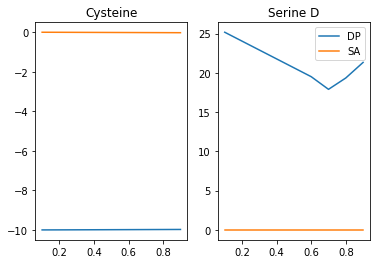

In [44]:
fig, axs = plt.subplots(1,2)
axs[0].set_title("Cysteine")
axs[0].plot(alphas, cysteine_DP)
axs[0].plot(alphas, cysteine_SA)
axs[1].set_title("Serine D")
axs[1].plot(alphas, serine_DP)
axs[1].plot(alphas, serine_SA)
axs[1].legend(["DP", "SA"])
fig.savefig("Serien_cyteine_plot_RM.pdf")

## Glucose dependence?

In [45]:
# For community 
model.set_weights([1,10])
model.slim_optimize()
medium = model.medium
glc = np.linspace(0,100,100) 
growth = []
for g in glc:
    medium["EX_glc__D_e"] = g 
    model.set_medium(medium)
    growth.append(model.slim_optimize())

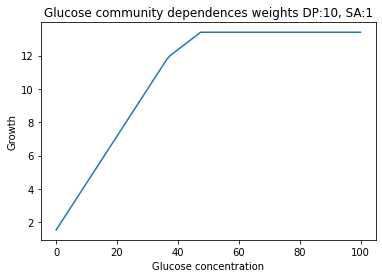

In [46]:
plt.plot(glc, growth)
plt.xlabel("Glucose concentration")
plt.ylabel("Growth")
plt.title("Glucose community dependences weights DP:10, SA:1")
plt.ylabel("Growth")
plt.savefig("community_glucose_dependence_weights10_1_RM.png")

In [47]:
# Growth without glucose
growth[0]

1.5457511759833413

In [48]:
# For community 
model.set_weights([1,1])
model.slim_optimize()
medium = model.medium
glc = np.linspace(0,100,100) 
growth = []
for g in glc:
    medium["EX_glc__D_e"] = g 
    model.set_medium(medium)
    growth.append(model.slim_optimize())

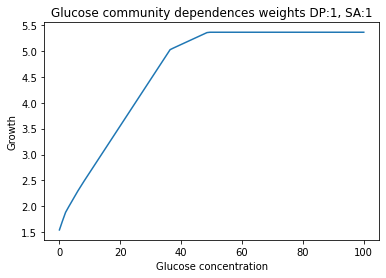

In [49]:
plt.plot(glc, growth)
plt.xlabel("Glucose concentration")
plt.ylabel("Growth")
plt.title("Glucose community dependences weights DP:1, SA:1")
plt.savefig("community_glucose_dependence_weights1_1_RM.png")

In [23]:
# Growth without glucose
growth[0]

1.5457511759833893

In [50]:
# For single models
model_DP = cobra.io.read_sbml_model("models/consistent_DP_SNM.xml")
model_SA = cobra.io.read_sbml_model("models/consistent_iYS854_SNM.xml")
print("Growth: ", model_DP.slim_optimize())
print("Growth: ", model_SA.slim_optimize())

Growth:  0.282365392532252
Growth:  2.558694612613397


Text(0.5, 0, 'glc concentration')

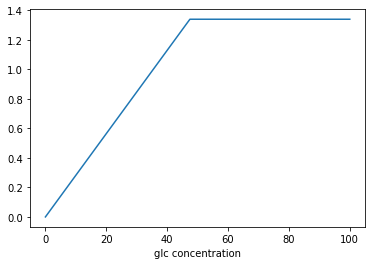

In [51]:
growths = []
x = np.linspace(0,100,100)
for c in x:
    with model_DP as model:
        medium = model.medium 
        medium["EX_glc__D_e"] = c 
        model.medium = medium 
        growths.append(model.slim_optimize())
plt.plot(x,growths)
plt.xlabel("glc concentration") 

Text(0.5, 0, 'glc concentration')

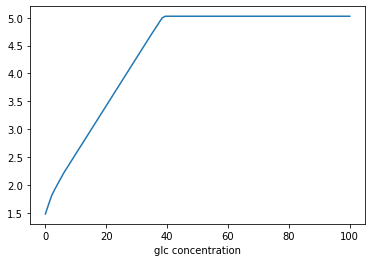

In [52]:
growths = []
x = np.linspace(0,100,100)
for c in x:
    with model_SA as model:
        medium = model.medium 
        medium["EX_glc__D_e"] = c 
        model.medium = medium 
        growths.append(model.slim_optimize())
plt.plot(x,growths)
plt.xlabel("glc concentration")         